In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models,transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [2]:
mean = np.array([0.5,0.5,0.5])
std = np.array([0.25,0.25,0.25])

In [5]:
data_transforms =  {"train": transforms.Compose([transforms.RandomResizedCrop(224),
                                                transforms.RandomHorizontalFlip(),
                                                transforms.ToTensor(),
                                                transforms.Normalize(mean, std)]),
                   "val" : transforms.Compose([transforms.Resize(256),
                                               transforms.CenterCrop(224),
                                               transforms.ToTensor(),
                                               transforms.Normalize(mean,std)])}

In [12]:
data_dir = 'hymenoptera_data/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(class_names)

['ants', 'bees']


In [14]:
def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()

In [15]:
inputs, classes = next(iter(dataloaders['train']))

In [16]:
out = torchvision.utils.make_grid(inputs)

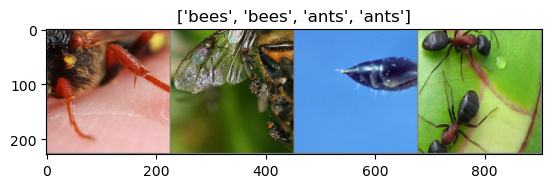

In [17]:
imshow(out, title=[class_names[x] for x in classes])

In [18]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [19]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

C:\Users\hilal\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\hilal\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\hilal/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:15<00:00, 2.98MB/s]


In [20]:
model = model.to(device)

In [21]:
criterion = nn.CrossEntropyLoss()

In [22]:
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [23]:
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [25]:
model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.7288 Acc: 0.4959
val Loss: 0.5519 Acc: 0.7190

Epoch 1/24
----------
train Loss: 0.5293 Acc: 0.7582
val Loss: 0.4162 Acc: 0.8889

Epoch 2/24
----------
train Loss: 0.4170 Acc: 0.8402
val Loss: 0.3074 Acc: 0.9085

Epoch 3/24
----------
train Loss: 0.4199 Acc: 0.8361
val Loss: 0.2653 Acc: 0.9412

Epoch 4/24
----------
train Loss: 0.4029 Acc: 0.8156
val Loss: 0.2448 Acc: 0.9281

Epoch 5/24
----------
train Loss: 0.3620 Acc: 0.8770
val Loss: 0.2232 Acc: 0.9346

Epoch 6/24
----------
train Loss: 0.4169 Acc: 0.7910
val Loss: 0.2261 Acc: 0.9346

Epoch 7/24
----------
train Loss: 0.3479 Acc: 0.8607
val Loss: 0.2477 Acc: 0.9216

Epoch 8/24
----------
train Loss: 0.3407 Acc: 0.8484
val Loss: 0.2389 Acc: 0.9281

Epoch 9/24
----------
train Loss: 0.3112 Acc: 0.8852
val Loss: 0.2139 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.3325 Acc: 0.8443
val Loss: 0.2129 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.3679 Acc: 0.8279
val Loss: 0.2086 Acc: 0.9412

Ep

In [26]:
model_conv = torchvision.models.resnet18(pretrained=True)

In [27]:
for param in model_conv.parameters():
    param.requires_grad = False

In [28]:
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

In [29]:
model_conv = model_conv.to(device)

In [30]:
criterion = nn.CrossEntropyLoss()

In [31]:
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

In [32]:
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [33]:
model_conv = train_model(model_conv, criterion, optimizer_conv,exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6071 Acc: 0.7008
val Loss: 0.3611 Acc: 0.8235

Epoch 1/24
----------
train Loss: 0.4285 Acc: 0.8033
val Loss: 0.2446 Acc: 0.9281

Epoch 2/24
----------
train Loss: 0.4146 Acc: 0.8320
val Loss: 0.1617 Acc: 0.9477

Epoch 3/24
----------
train Loss: 0.5397 Acc: 0.7705
val Loss: 0.2825 Acc: 0.9085

Epoch 4/24
----------
train Loss: 0.6128 Acc: 0.7582
val Loss: 0.1716 Acc: 0.9608

Epoch 5/24
----------
train Loss: 0.4023 Acc: 0.8361
val Loss: 0.2248 Acc: 0.9281

Epoch 6/24
----------
train Loss: 0.4078 Acc: 0.8402
val Loss: 0.1959 Acc: 0.9412

Epoch 7/24
----------
train Loss: 0.3669 Acc: 0.8443
val Loss: 0.1770 Acc: 0.9542

Epoch 8/24
----------
train Loss: 0.3426 Acc: 0.8566
val Loss: 0.1844 Acc: 0.9542

Epoch 9/24
----------
train Loss: 0.3303 Acc: 0.8689
val Loss: 0.1742 Acc: 0.9542

Epoch 10/24
----------
train Loss: 0.3655 Acc: 0.8443
val Loss: 0.1809 Acc: 0.9542

Epoch 11/24
----------
train Loss: 0.4377 Acc: 0.8033
val Loss: 0.1688 Acc: 0.9477

Ep